The first part of the code constructs the transmon system and implements the functions used in subsequent simulations.

The second part optimizes the parameters for $\pi$ and DRAG pulses, and for the latter generates error arrays for their Rabi frequency, anharmonicity, and qubit frequency variations.

The final part presents the results for the Composite Pulses (CP) gates, including the key plots from the paper along with additional supporting materials.

In [1]:
# Import necessary libraries
from qutip import *
from scipy.optimize import minimize
from matplotlib import ticker,cm
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import scqubits as scq
from qiskit.quantum_info import Pauli
import matplotlib.image as mpimg
from io import BytesIO
import scipy.linalg
import numpy as np
import svgutils.transform as sg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from qutip import Qobj, Bloch, basis
from PIL import Image
from pathlib import Path
from IPython.display import Image as IPimager
from IPython.display import display as IPdisplay
#scq.set_units('GHz')

(CVXPY) Apr 30 02:46:51 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: The specified module could not be found.')
(CVXPY) Apr 30 02:46:51 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: The specified module could not be found.')
(CVXPY) Apr 30 02:46:51 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: The specified module could not be found.')


In [2]:
T = 20. #Gate time in ns
desired_w = 7*2*np.pi  # Desired frequency in GHz
desired_anharm = -0.3*2*np.pi # Desired anharmonicity in GHz
sigma = T/4 # Gaussian width in ns
dims = 6 # Truncated dimension of the transmon in the energy basis

EJ = 153.07492694351913 # Josephson energy in GHz
EC = 1.710205326229512 # Charging energy in GHz

# Create a transmon object with the specified parameters
transmon = scq.Transmon(EJ = EJ, 
                        EC = EC,
                              ng = 0.,
                              ncut = 30, #   2*ncut + 1 is the number of levels in the charge basis
                              truncated_dim = dims,
                              )

In [ ]:
n = transmon.n_operator(energy_esys=False) # Charge operator in the charge basis
cos_phi = transmon.cos_phi_operator(energy_esys=False) # Cosine of the flux operator in the charge basis
energi = transmon.eigenvals() # Eigenvalues of the transmon
H = 4*EC*np.matmul(n,n) - EJ*cos_phi- energi[0]*np.eye(len(n)) # Hamiltonian in the charge basis with an offset
Energies,eigenvectors = scipy.linalg.eigh(H) # Eigenvalues and eigenvectors of the Hamiltonian
Transiton_n = eigenvectors.conj().T @ n @ eigenvectors # Charge operator in the energy basis

lambdi = [] # List to store the coupling coefficients
for j in range(len(Transiton_n)-1):
    lambdi.append(Transiton_n[j+1,j])
metrika = np.array([-1,-1,1,1,-1])                     # fix the sign of the coupling coefficients
for j in range(len(Transiton_n)-1):
       lambdi.append(Transiton_n[j+1,j])
if dims == 6:
     lambdi = np.abs(lambdi)[:dims-1] * metrika


def generate_and_compute_Hamiltonian(EJ1,EC1,Omega_t,phi,omdi,epsilon,CP = False,real = True, dims = dims):
    transmon = scq.Transmon(EJ = EJ1,
                        EC = EC1,
                              ng = 0.,
                              ncut = 30,
                              truncated_dim = dims,
                              )
    n = transmon.n_operator(energy_esys=False) # Charge operator in the charge basis
    cos_phi = transmon.cos_phi_operator(energy_esys=False) # Cosine of the flux operator in the charge basis
    energi = transmon.eigenvals() # Eigenvalues of the transmon

    H = 4*EC1*np.matmul(n,n) - EJ1*cos_phi - energi[0]*np.eye(len(n)) # Hamiltonian in the charge basis with an offset
    Energies,eigenvectors = scipy.linalg.eigh(H)           # Eigenvalues and eigenvectors of the Hamiltonian
    Transiton_n = eigenvectors.conj().T @ n @ eigenvectors # Charge operator in the energy basis
    
    lambdi_in = []                                         # List to store the coupling coefficients
    metrika = np.array([-1,-1,1,1,-1])                     # fix the sign of the coupling coefficients
    for j in range(len(Transiton_n)-1):
       lambdi_in.append(Transiton_n[j+1,j])
    if dims == 6:
     lambdi_in = np.abs(lambdi_in)[:dims-1] * metrika

    if CP:
     return compute_hamiltonian(Omega_t, phi,e_vals = Energies,lambda_vals = lambdi_in ,n_cut = 30,omega_d = omdi,epsilon = epsilon,dim = dims)
    else:
      return drag_control_hamiltonian(real = real,lambda_vals = lambdi_in ,dim = dims)

    
def compute_hamiltonian(Omega_t, phi,e_vals = Energies,lambda_vals = lambdi ,n_cut = 30,omega_d = desired_w,epsilon = 0.,dim = dims):
    H = np.zeros((dim, dim), dtype=complex)
    # Compute diagonal terms: mu_j * Pi_j
    for j in range(dim):
        mu_j = e_vals[j] - j * e_vals[1] # Energy offset in the rotating frame
        H[j, j] = mu_j
    
    # Compute off-diagonal terms: (Omega_R(t)/2) * lambda_{j, j-1} |j><j-1| + h.c.
    Omega_R_t = Omega_t * np.exp(-1j * phi)*(1+epsilon)
    for j in range(1, dim):
        H[j, j-1] = (Omega_R_t / 2) * lambda_vals[j-1]
        H[j-1, j] = np.conjugate(H[j, j-1])  # Hermitian conjugate part
    
    return H

def drag_control_hamiltonian(real = True,lambda_vals = lambdi ,dim = dims):
    H = np.zeros((dim, dim), dtype=complex)    
    if real:
     for j in range(1, dim):
        H[j, j-1] = (1 / 2) * lambda_vals[j-1]
        H[j-1, j] = np.conjugate(H[j, j-1])  # Hermitian conjugate part
    else:
        for j in range(1, dim):
            H[j, j-1] = (1j / 2) * lambda_vals[j-1]
            H[j-1, j] = np.conjugate(H[j, j-1])
    return H

def Half_control_Hamiltonian(n = 6, lambdi = lambdi):
     Lower_Half = np.zeros((n, n), dtype=complex)
     Upper_Half = np.zeros((n, n), dtype=complex)
     for j in range(1,n):
        Lower_Half[j,j-1] = (1 / 2) * lambdi[j-1]
        Upper_Half[j-1,j] = (1 / 2) * lambdi[j-1]
     return Lower_Half, Upper_Half

def time_dependent_cp(lambdi, Rabbi, phi, dt, N,e):    
    def Omega_t(t, **kwargs):
        e = kwargs['e']
        Rabbi = kwargs['Rabbi']
        phi = kwargs['phi']
        dt = kwargs['dt']
        for j in range(len(Rabbi)):
            if j * dt <= t <= (j + 1) * dt:
                return (1 + e) * Rabbi[j] * np.exp(-1j * phi[j])
        return 0  # Default return value
    def Omega_t_conj(t, **kwargs):
        e = kwargs['e']
        Rabbi = kwargs['Rabbi']
        phi = kwargs['phi']
        dt = kwargs['dt']
        for j in range(len(Rabbi)):
            if j * dt <= t <= (j + 1) * dt:
                return (1 + e) * Rabbi[j] * np.exp(1j * phi[j])
        return 0  # Default return value
    
    H0 = np.diag(compute_hamiltonian(1, 0).diagonal())
    H1 , H2 = Half_control_Hamiltonian(n=6, lambdi=lambdi)

    H = [Qobj(H0),[Qobj(H1),Omega_t],[Qobj(H2),Omega_t_conj]]
    U = propagator(H, dt * N, args={'e': e, 'Rabbi': Rabbi, 'phi': phi,'dt': dt}, options=Options(nsteps=100000)).full()
    return U

def Omega_G(t): #Gaussian envelope function, taken from: J. M. Gambetta, F. Motzoi, S. T. Merkel, and F. K. Wil- helm. Analytic control methods for high-fidelity unitary operations in a weakly nonlinear oscillator. Physical Re- view A, 83(1), January 2011.
    global sigma
    amp = np.pi

    t_g = 4*sigma
    return amp*(np.exp(-((t-t_g/2)**2)/(2*sigma**2))-np.exp(-((t_g)**2)/(8*sigma**2)))/(np.sqrt(2*np.pi*sigma**2)*math.erf(t_g/(np.sqrt(8)*sigma))-t_g*np.exp(-t_g**2/(8*sigma**2)))

def dOmega_dt(t): #Derivative of the Gaussian envelope function
      global sigma
      amp = np.pi
      t_g = 4*sigma
      return -((t-t_g/2))/(sigma**2)*amp*(np.exp(-((t-t_g/2)**2)/(2*sigma**2)))/(np.sqrt(2*np.pi*sigma**2)*math.erf(t_g/(np.sqrt(8)*sigma))-t_g*np.exp(-t_g**2/(8*sigma**2)))

def dragi(x,*args,**kwargs): # Scaled derivative of Omega(t)
    global desired_anharm
    beta = kwargs['beta']
    eps = kwargs['e']
    lambda_1 = 1.7535243509438676*(1.7535243509438676) # Coupling coefficient between the first excited and second excited states
    coefficient = -beta*lambda_1/desired_anharm
    chislo = float((1+eps)*coefficient*dOmega_dt(float(x)))
    return chislo

def drag(x,*args,**kwargs):  # Scaled Omega(t)
    alpha = kwargs['alpha']
    eps = kwargs['e']
    chislo = float(alpha*Omega_G(x)*(1+eps))
    return chislo

def create_gate(which,levels):          # Function to create gates with which to compare the generated Propagator
    array = np.diag(np.ones(levels)).astype(np.complex128)
    if which == 'X':
      array[0][0] = 0.
      array[0][1] = 1.
      array[1][0] = 1.
      array[1][1] = 0.
    elif which == 'T':
        array[1][1] = np.exp(1j*np.pi/4)
    elif which == 'H':
      array[0][0] = 1/np.sqrt(2)
      array[0][1] = 1./np.sqrt(2)
      array[1][0] = 1/np.sqrt(2)
      array[1][1] = -1/np.sqrt(2)
    elif which == 'sqrtX':
      array[0][0] = 1/2*(1j+1)
      array[0][1] = 1/2*(-1j+1)
      array[1][0] = 1/2*(-1j+1)
      array[1][1] = 1/2*(1j+1)
    return array

def optimal_trace(U,G,n = 2,seperate = False): # Fidelity function taken from https://arxiv.org/pdf/quant-ph/0701138.pdf equation (3)
  projector = np.zeros_like(U)
  projector[:n,:n] = np.diag(np.ones(n))
  M = np.matmul(projector,np.transpose(np.conj(G)))
  M = np.matmul(M,U)
  M = np.matmul(M,projector)
  Fidelity = 1/(n*(n+1))*(np.trace(np.matmul(M,np.transpose(np.conj(M))))+np.square(np.abs(np.trace(M))))
  if seperate:
     non_unitarnost = np.trace(np.matmul(M,np.transpose(np.conj(M))))/n
     other = np.abs(np.trace(M))/n
     return 1-Fidelity.real,1-non_unitarnost.real,1-other.real
  else:
     return 1-Fidelity.real

def decompose_to_pauli(matrix, delta=0.): # Decomposes a matrix into Pauli basis
    n = len(matrix)
    P_comp = (basis(n, 0)*basis(n, 0).dag() \
           + basis(n, 1)*basis(n, 1).dag()).full()
    # Define Pauli matrices
    matrix = (P_comp @ matrix @ P_comp)[:2,:2]

    I = Pauli('I').to_matrix()
    sigma_x = Pauli('X').to_matrix()
    sigma_y = Pauli('Y').to_matrix()
    sigma_z = Pauli('Z').to_matrix()

    # List of Pauli matrices
    paulis = [I, sigma_x, sigma_y, sigma_z]

    # Compute coefficients c_i
    coefficients = []
    for pauli in paulis:
        coeff = np.trace(np.dot(matrix, pauli)) / 2
        coefficients.append(coeff)

    # Apply the (1 - delta) factor
    coefficients = [(1 - delta)*  c for c in coefficients]

    return coefficients

def Cost_function(x,*argsa): # Cost function for the optimization process
    number_of_pulses = argsa[0]
    t_g = argsa[1]/number_of_pulses
    Prob = argsa[2]
    epsillon = argsa[3]
    operator = argsa[4]
    system_size = argsa[6]
    error = 0.
    
    for eps in epsillon:
     U_f = np.diag(np.ones(system_size).astype(np.complex128))
     if system_size != 0:
         global EJ,EC,desired_w
         for j in range(number_of_pulses):
          U_f = np.matmul(scipy.linalg.expm(-1j*t_g*generate_and_compute_Hamiltonian(EJ,EC,x[j],x[j+len(x)//2],desired_w,0.,CP = True, dims = system_size)),U_f)
     else:
         for j in range(number_of_pulses):
           U_f = np.matmul(scipy.linalg.expm(-1j*t_g*compute_hamiltonian(x[j],x[j+len(x)//2],epsilon=eps)),U_f)
     
     if operator:
       error += optimal_trace(U_f,argsa[5],n = 2)
     else:
        for vam in range(2):
            error += np.abs(Prob[vam]-np.conj(U_f[vam,0])*U_f[vam,0])/2
    return error/len(epsillon)

def infidelity_operator(parameters,initial_sizes = [6],operatora = 'X',name = "",N = 7,T = T,prob = [0.,1.],vernoliop = False): # plots the infidelity for a varying system size assuming no error in the system
  for na in initial_sizes:
      mia = []
      x = np.arange(2,21)
      for j in x:
        operator = create_gate(operatora,j)
        plotnato = Cost_function(parameters,N,T,prob,[0.],vernoliop,operator,j)
        mia.append(plotnato)    

      plt.rcParams.update({
      "text.usetex": False,           # Change to True if you want to use LaTeX for text rendering
      "font.family": "serif",
      "font.serif": ["Times New Roman"],
      "font.size": 16.5})
      
      plt.plot(x,np.array(mia),'g',label=f"n = {na}")
      plt.legend()
      plt.xlim(2,21)
      plt.xlabel(r"$n_j$")
      if vernoliop:
       plt.ylabel(r"$\mathrm{Infidelity}_{n_j}$")
      else:
         plt.ylabel(r"$Error_{n_j}$")
      plt.yscale('log')
      plt.savefig(f"Infidelity_{name}.pdf")
      plt.show()
      plt.close()

def error(params): # Error function to compute optimal EJ and EC for desired frequency and anharmonicity
    global desired_anharmonicity, desired_frequency
    EJ, EC = params
    transmon = scq.Transmon(EJ=EJ, EC=EC, ng=0, ncut=22)
    spectrum = transmon.eigenvals()
    actual_frequency = spectrum[1] - spectrum[0]  # Transition frequency between first and second levels
    actual_anharmonicity = spectrum[2] - 2 * spectrum[1] + spectrum[0]  # Anharmonicity
    return (actual_frequency - desired_frequency)**2 + (actual_anharmonicity - desired_anharmonicity)**2

In [ ]:
def plot_with_inset(epsilon, cp_precise, cp_robust, drag, pi_pulse, name='', pi_name=r'$\pi$-pulse',operari = False):
    plt.rcParams.update({
      "text.usetex": False,   # Change to True if you want to use LaTeX for text rendering
      "font.family": "serif",
      "font.serif": ["Times New Roman"],
      "font.size": 16.5})
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 5))

    # Plot main curves
    ax.plot(epsilon, cp_precise, ':', linewidth=3, label='CP-precise')
    ax.plot(epsilon, cp_robust, 'orange', linestyle='--', linewidth=2, label='CP-robust')
    ax.plot(epsilon, drag, 'g-', linewidth=2, label='DRAG')
    ax.plot(epsilon, pi_pulse, 'r-.', linewidth=2, label=pi_name)

    # Log scale for Y-axis
    ax.set_yscale('log')

    # Labels and title
    if len(epsilon)>700:
     ax.set_xlabel(r'Qubit Frequency $\omega$ [$2 \pi \times \mathrm{GHz}$]', fontsize=16.5)
    else:
      ax.set_xlabel(r'Rabi Frequency Deviation $\epsilon$', fontsize=16.5)
    if operari:
       ax.set_ylabel('Infidelity', fontsize=13)
    else:
       ax.set_ylabel('Error', fontsize=16.5)
    ax.legend(loc='lower left', fontsize=15, framealpha=1)

    # Inset plot
    N = np.argmin(cp_precise)
    N_cut = int(0.1 * N)
    plt.rcParams.update({
      "text.usetex": False,        # Change to True if you want to use LaTeX for text rendering
      "font.family": "serif",
      "font.serif": ["Times New Roman"],
      "font.size": 14.5})
    ax_inset = fig.add_axes([0.65, 0.19, 0.22, 0.22])  # Position: [left, bottom, width, height]
    ax_inset.plot(epsilon[N-N_cut:N+N_cut], cp_precise[N-N_cut:N+N_cut],":", linewidth=3)
    ax_inset.plot(epsilon[N-N_cut:N+N_cut], cp_robust[N-N_cut:N+N_cut], 'orange', linestyle='--', linewidth=2)
    ax_inset.plot(epsilon[N-N_cut:N+N_cut], drag[N-N_cut:N+N_cut], 'g-', linewidth=2)
    ax_inset.plot(epsilon[N-N_cut:N+N_cut], pi_pulse[N-N_cut:N+N_cut], 'r-.', linewidth=2)

    ax_inset.set_yscale('log')
    ax_inset.set_xticks([])
    if name == f'pop_trans' or name == f'pop_trans_qubit_frequency':
       ax_inset.set_yticks([10**-3,10**-5,10**-7,10**-9])
    elif name == f'half_pop_trans_qubit_frequency':
         ax_inset.set_yticks([10**-3,10**-5,10**-7])
    elif name == f'half_pop_trans':
       ax_inset.set_yticks([10**-1,10**-3,10**-5,10**-7])
    elif name == f'sqrtX_gate' or name == f'sqrtX_gate_qubit_frequency':
       ax_inset.set_yticks([10**-3,10**-5,10**-7])
    elif name == f'X_gate' or name == f'X_gate_qubit_frequency':
       ax_inset.set_yticks([10**-3,10**-5,10**-7])
    #ax_inset.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
    if len(epsilon)<700:
      eps_subset = epsilon[N-N_cut:N+N_cut]          
      half_width = max(abs(eps_subset))              # make it symmetric about 0
      ax_inset.set_xlim(-half_width,  half_width)    # lock the limits
      ax_inset.set_xticks(np.linspace(-half_width, half_width, 3))  # ② place 3 ticks

    else:
      ax_inset.set_xticks([6.95,7.,7.05])
    ax_inset.xaxis.set_major_formatter(
         ticker.FormatStrFormatter('%0.02f'))   # format as –0.02, …, 0.02
    
    # Show plot


    plt.savefig(f'{name}.svg')
    plt.show()
    plt.close()

    return

def color_plot(x,y,z,name = "generic"):
 X, Y = np.meshgrid(x, y)

 fig, ax = plt.subplots()
 cs = ax.contourf(X, Y, z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
 cbar = fig.colorbar(cs)
 plt.xlabel(r'Anharmonicity $\delta$ [$2 \pi \times \mathrm{GHz}$]',size = 14.5)
 plt.ylabel(r'Qubit Frequency $\omega$ [$2 \pi \times \mathrm{GHz}$]',size = 14.5)
 plt.xticks(fontsize=14.5)
 plt.yticks(fontsize=14.5)
 cbar.ax.tick_params(labelsize=14.5)
 
 plt.savefig(f'{name}.svg')
 plt.show()
 plt.close()
 return


In [5]:
# Find optimal coefficients for the Rabi frequencies in the pi pulses, to take in to account the higher levels of the transmon
def pi_pulse_full_pop(x):
    results_ops = scipy.linalg.expm(-1j*T*compute_hamiltonian(np.pi/T*x,0.))
    return np.abs(1-np.conj(results_ops[1, 0])*results_ops[1, 0])/2+np.abs(0-np.conj(results_ops[0, 0])*results_ops[0, 0])/2

def pi_pulse_half_pop(x):
    results_ops = scipy.linalg.expm(-1j*T*compute_hamiltonian(np.pi/T*x,0.))
    return np.abs(0.5-np.conj(results_ops[1, 0])*results_ops[1, 0])/2+np.abs(0.5-np.conj(results_ops[0, 0])*results_ops[0, 0])/2

def pi_2_pulse_sqrt(x,*args):
    results_ops = scipy.linalg.expm(-1j*T*compute_hamiltonian(np.pi/T*x,0.))
    return optimal_trace(results_ops, create_gate('sqrtX',6), n = 2)

def pi_pulse_X(x,*args):
    results_ops = scipy.linalg.expm(-1j*T*compute_hamiltonian(np.pi/T*x,0.))
    return optimal_trace(results_ops, create_gate('X',6), n = 2)

res_y = minimize(pi_pulse_full_pop,np.array([1.]))
res_y_half = minimize(pi_pulse_half_pop,np.array([1.]))
res_y_X = minimize(pi_pulse_X,np.array([1.]))
res_y_half_sqrt = minimize(pi_2_pulse_sqrt,np.array([1.]))

In [6]:
#Create DRAG Hamiltonian that can be used in qutip
diag_elements = compute_hamiltonian(1, 0).diagonal()
X_drag = drag_control_hamiltonian(real = True)
Y_drag = drag_control_hamiltonian(real = False)
H = [Qobj(np.diag(diag_elements)),[Qobj(X_drag),drag],[Qobj(Y_drag),dragi]]
times = np.linspace(0,T,2)
# Functions to find the optimal alpha and beta coefficents for DRAG
def drag_optim(x,*argsi):
    result_ops = propagator(argsi[0][0], argsi[0][1],args= {'beta':x[0],'alpha':x[1],'e':0.},options = Options(nsteps=1000000)).full()
     
    return np.abs(1-np.conj(result_ops[1, 0])*result_ops[1, 0])/2+np.abs(0-np.conj(result_ops[0, 0])*result_ops[0, 0])/2

def drag_optim_X(x,*argsi):
    result_ops = propagator(argsi[0][0], argsi[0][1],args= {'beta':x[0],'alpha':x[1],'e':0.},options = Options(nsteps=1000000)).full()
    return optimal_trace(result_ops, create_gate('X',6), n = 2)

def drag_optim_sqrtX(x,*argsi):
    result_ops = propagator(argsi[0][0], argsi[0][1],args= {'beta':x[0],'alpha':x[1],'e':0.},options = Options(nsteps=1000000)).full()
    return optimal_trace(result_ops, create_gate('sqrtX',6), n = 2)

def drag_optim_half(x,*argsi):
    result_ops = propagator(argsi[0][0], argsi[0][1],args= {'beta':x[0],'alpha':x[1],'e':0.},options = Options(nsteps=1000000)).full()
     
    return np.abs(0.5-np.conj(result_ops[1, 0])*result_ops[1, 0])/2+np.abs(0.5-np.conj(result_ops[0, 0])*result_ops[0, 0])/2
known = True # True if you want to use the precomputed values for the coefficients, False if you want to compute them again
if known:
    res_x = np.load("Parameters\\Drag_res_x_300_7_T_20.npy")
    res_x_ops = np.load("Parameters\\Drag_res_x_ops_300_7_T_20.npy")
    res_x_ops_sqrt = np.load("Parameters\\Drag_res_x_ops_sqrt_300_7_T_20.npy")
    res_x_ops_half = np.load("Parameters\\Drag_res_x_ops_half_300_7_T_20.npy")
else:
 res_x = minimize(drag_optim,np.array([1.,1.]),args = [H,T])
 res_x_ops = minimize(drag_optim_X,np.array([1.,1.]),args = [H,T])
 res_x_ops_sqrt = minimize(drag_optim_sqrtX,np.array([1.,1.]),args = [H,T])
 res_x_ops_half = minimize(drag_optim_half,np.array([1.,1.]),args = [H,T])

 np.save("Parameters\\Drag_res_x_300_7_T_20.npy", res_x.x)
 np.save("Parameters\\Drag_res_x_ops_300_7_T_20.npy", res_x_ops.x)
 np.save("Parameters\\Drag_res_x_ops_sqrt_300_7_T_20.npy", res_x_ops_sqrt.x)
 np.save("Parameters\\Drag_res_x_ops_half_300_7_T_20.npy", res_x_ops_half.x)

In [7]:
known = True # True if you want to use the precomputed values for the Rabi Frequency DRAG plots, False if you want to compute them 
if not known:
  answer,answer1,answer_2,answer1_2 = [],[],[],[]
  epsilon = np.arange(-0.2,0.21,0.001)
  for e in epsilon:
   result_ops = propagator(H, T,args= {'beta':res_x[0],'alpha':res_x[1],'e':e},options = Options(nsteps=1000000)).full()
   result_ops_x = propagator(H, T,args= {'beta':res_x_ops[0],'alpha':res_x_ops[1],'e':e},options = Options(nsteps=1000000)).full()
  
   answer.append(np.abs(0-np.conj(result_ops[0, 0])*result_ops[0, 0])/2+np.abs(1-np.conj(result_ops[1, 0])*result_ops[1, 0])/2)
   answer1.append(optimal_trace(result_ops_x, create_gate('X',6), n = 2))

   result_ops_2 = propagator(H, T,args= {'beta':res_x_ops_half[0],'alpha':res_x_ops_half[1],'e':e},options = Options(nsteps=1000000)).full()
   result_ops_2_sqrt = propagator(H, T,args= {'beta':res_x_ops_sqrt[0],'alpha':res_x_ops_sqrt[1],'e':e},options = Options(nsteps=1000000)).full()
  
   answer_2.append(np.abs(0.5-np.conj(result_ops_2[0, 0])*result_ops_2[0, 0])/2+np.abs(0.5-np.conj(result_ops_2[1, 0])*result_ops_2[1, 0])/2)
   answer1_2.append(optimal_trace(result_ops_2_sqrt, create_gate('sqrtX',6), n = 2))
else:
  answer1 = np.load("Parameters\\answer1_300_7_T_20.npy")
  answer = np.load("Parameters\\answer_300_7_T_20.npy")
  answer_2 = np.load("Parameters\\answer_2_300_7_T_20.npy")
  answer1_2 = np.load("Parameters\\answer1_2_300_7_T_20.npy")
  epsilon = []
if not known:
  np.save("Parameters\\answer_300_7_T_20.npy", answer)
  np.save("Parameters\\answer1_300_7_T_20.npy", answer1)
  np.save("Parameters\\answer1_2_300_7_T_20.npy", answer1_2)
  np.save("Parameters\\answer_2_300_7_T_20.npy", answer_2)


In [8]:
initial_guess = [10.0,0.]

known  = True # True if you want to use the precomputed values for the optimal EJ and EC, False if you want to compute them again
if known:
   solutions_EJ = np.load("Parameters\\solutions_EJ_300_7.npy")
   solutions_EC = np.load("Parameters\\solutions_EC_300_7.npy")
   delta_range = []
   omega_range = []
else:
 delta_range = np.arange(-0.33,-0.27,0.0005)
 omega_range = np.arange(6.5, 7.5, 0.001)
 solutions_EC = np.zeros((len(omega_range),len(delta_range)))
 solutions_EJ = np.zeros((len(omega_range),len(delta_range)))
 for index_w,w in enumerate(omega_range):
  print(index_w)
  for index_delta,delta in enumerate(delta_range):
    desired_frequency = 2*np.pi*w  # Frequency in GHz
    desired_anharmonicity = 2*np.pi*delta # Anharmonicity in GHz

    # Perform optimization to find the parameters that minimize the error
    result = minimize(error, initial_guess)

    # Extract the optimized parameters
    optimal_EJ,optimal_EC = result.x
    solutions_EJ[index_w,index_delta] = optimal_EJ
    solutions_EC[index_w,index_delta] = optimal_EC

 np.save("Parameters\\solutions_EJ_300_7.npy", solutions_EJ)
 np.save("Parameters\\solutions_EC_300_7.npy", solutions_EC)

In [9]:
known = True # True if you want to use the precomputed values for the qubit frequency and anharmonicity DRAG plots, False if you want to compute them again
if known:
  answer2 = np.load('Freq_anharm\\2d_DRAG_pop_trans.npy')
  answer3 = np.load('Freq_anharm\\2d_DRAG_X.npy')
  answer2_sqrt = np.load("Freq_anharm\\2d_DRAG_half_pop_trans.npy")
  answer3_sqrtX = np.load('Freq_anharm\\2d_DRAG_sqrtX.npy')
else:
 answer2 = np.zeros((len(solutions_EJ),len(solutions_EC[0])))
 answer2_sqrt = np.zeros((len(solutions_EJ),len(solutions_EC[0])))
 answer3_sqrtX = np.zeros((len(solutions_EJ),len(solutions_EC[0])))
 answer3 = np.zeros((len(solutions_EJ),len(solutions_EC[0])))

omega_range = 2*np.pi*np.arange(6.5, 7.5, 0.001)
anharm_range = np.arange(-0.33,-0.27,0.0005)
twod = True # True if you want to compute the 2D anharmonicity and qubit frequency plots, False if you want to compute the 1d qubit frequency plots
if not known:
 if twod:
  for i in range(len(solutions_EJ)):
   for j in range(len(solutions_EC[0])):
    Ha = generate_and_compute_Hamiltonian(solutions_EJ[i,j],solutions_EC[i,j],1,0.,omega_range[i],0.,CP = True,real = True)
    diag_elements = Ha.diagonal()
    X_drag = generate_and_compute_Hamiltonian(solutions_EJ[i,j],solutions_EC[i,j],1,0.,omega_range[i],0.,CP = False,real = True)
    Y_drag = generate_and_compute_Hamiltonian(solutions_EJ[i,j],solutions_EC[i,j],1,0.,omega_range[i],0.,CP = False,real = False)
    H_anharm = [Qobj(np.diag(diag_elements)),[Qobj(X_drag),drag],[Qobj(Y_drag),dragi]]
    
    result_ops = propagator(H_anharm, T,args= {'beta': res_x[0],'alpha':res_x[1],'e':0.},options = Options(nsteps=1000000)).full()
    result_ops_X = propagator(H_anharm, T,args= {'beta': res_x_ops[0],'alpha':res_x_ops[1],'e':0.},options = Options(nsteps=1000000)).full()
    
    answer2[i,j] = np.abs(0-np.conj(result_ops[0, 0])*result_ops[0, 0])/2+np.abs(1-np.conj(result_ops[1, 0])*result_ops[1, 0])/2
    answer3[i,j] = optimal_trace(result_ops_X, create_gate('X',6), n = 2)
    
    result_ops_2 = propagator(H_anharm, T,args= {'beta': res_x_ops_half[0],'alpha':res_x_ops_half[1],'e': 0.},options = Options(nsteps=1000000)).full()
    result_ops_2_sqrt = propagator(H_anharm, T,args= {'beta': res_x_ops_sqrt[0],'alpha':res_x_ops_sqrt[1],'e':0.},options = Options(nsteps=1000000)).full()
    answer2_sqrt[i,j] = np.abs(0.5-np.conj(result_ops_2[0, 0])*result_ops_2[0, 0])/2+np.abs(0.5-np.conj(result_ops_2[1, 0])*result_ops_2[1, 0])/2
    answer3_sqrtX[i,j] = optimal_trace(result_ops_2_sqrt, create_gate('sqrtX',6), n = 2)

  #color_plot(delta_range,omega_range/2*np.pi,answer2,name = f"2d_Precise_DRAG_pop_trans")
  np.save(f"Freq_anharm\\2d_DRAG_pop_trans.npy",answer2)
  #color_plot(delta_range,omega_range/2*np.pi,answer3,name = f"2d_Precise_DRAG_X")
  np.save(f"Freq_anharm\\2d_DRAG_X.npy",answer3)
  #color_plot(delta_range,omega_range/2*np.pi,answer2_sqrt,name = f"2d_Precise_DRAG_half_pop_trans")
  np.save(f"Freq_anharm\\2d_DRAG_half_pop_trans.npy",answer2_sqrt)
  #color_plot(delta_range,omega_range/2*np.pi,answer3_sqrtX,name = f"2d_Precise_DRAG_sqrtX")
  np.save(f"Freq_anharm\\2d_DRAG_sqrtX.npy",answer3_sqrtX)
       
 else:
   omega = omega_range
   middle = int(len(anharm_range)/2)
   for j in range(len(solutions_EC)):
    Ha = generate_and_compute_Hamiltonian(solutions_EJ[j,middle],solutions_EC[j,middle],1,0.,omega[j],0.,CP = True,real = True)
    diag_elements = Ha.diagonal()
    X_drag = generate_and_compute_Hamiltonian(solutions_EJ[j,middle],solutions_EC[j,middle],1,0.,omega[j],0.,CP = False,real = True)
    Y_drag = generate_and_compute_Hamiltonian(solutions_EJ[j,middle],solutions_EC[j,middle],1,0.,omega[j],0.,CP = False,real = False)
    H_anharm = [Qobj(np.diag(diag_elements)),[Qobj(X_drag),drag],[Qobj(Y_drag),dragi]]
    result_ops = propagator(H_anharm, T,args= {'beta': res_x[0],'alpha':res_x[1],'e':0.},options = Options(nsteps=1000000)).full()
    result_ops_X = propagator(H_anharm, T,args= {'beta': res_x_ops[0],'alpha':res_x_ops[1],'e':0.},options = Options(nsteps=1000000)).full()

    answer2.append(np.abs(0-np.conj(result_ops[0, 0])*result_ops[0, 0])/2+np.abs(1-np.conj(result_ops[1, 0])*result_ops[1, 0])/2)
    answer3.append(optimal_trace(result_ops_X, create_gate('X',6), n = 2))
    
    result_ops_2 = propagator(H_anharm, T,args= {'beta': res_x_ops_half[0],'alpha':res_x_ops_half[1],'e': 0.},options = Options(nsteps=1000000)).full()
    esult_ops_2_sqrt = propagator(H_anharm, T,args= {'beta': res_x_ops_sqrt[0],'alpha':res_x_ops_sqrt[1],'e':0.},options = Options(nsteps=1000000)).full()

    answer2_sqrt[j,middle] = np.abs(0.5-np.conj(result_ops_2[0, 0])*result_ops_2[0, 0])/2+np.abs(0.5-np.conj(result_ops_2[1, 0])*result_ops_2[1, 0])/2
    answer3_sqrtX.append(optimal_trace(result_ops_2_sqrt, create_gate('sqrtX',6), n = 2))

 np.save("Freq_anharm\\2d_DRAG_pop_trans.npy",answer2)
 np.save("Freq_anharm\\2d_DRAG_X.npy", answer3)
 np.save("Freq_anharm\\2d_DRAG_half_pop_trans.npy", answer2_sqrt)
 np.save("Freq_anharm\\2d_DRAG_sqrtX.npy", answer3_sqrtX)

In [10]:
def plot_2d_qubit_anharmonicity(x,N = 6,T = T, operar = False,Prob = [0.,1.], ops = [],esuls = answer,pi_pulse = False,name = '',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = [],pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,pi_x_coef = res_y_X.x[0],drag_anharm_half = answer2_sqrt ):
    global solutions_EC,solutions_EJ         # The function plots the 2d error for the anharmonicity and qubit frequency, or the 1d error for the qubit frequency
    arr = np.zeros((len(solutions_EJ),len(solutions_EC[0])))
    arr_p = np.zeros((len(solutions_EJ),len(solutions_EC[0])))
    arr_2 = np.zeros((len(solutions_EJ),len(solutions_EC[0])))
    delta_range = 2*np.pi*np.arange(-0.33,-0.27,0.0005)
    omega_range = 2*np.pi*np.arange(6.5, 7.5, 0.001)

    if operar:
       opirar = create_gate(ops,dims)
       
    for i in range(len(solutions_EJ)):
     for ji in range(len(solutions_EC[0])):
      error,error_2,error_p = 0.,0.,0.
      U_f = np.diag(np.ones(dims).astype(np.complex128))
      U_f2 = np.diag(np.ones(dims).astype(np.complex128))
      if not pi_pulse:
       for j in range(N):
           Ham_tr = generate_and_compute_Hamiltonian(solutions_EJ[i,ji],solutions_EC[i,ji],x[j],x[j+len(x)//2],omega_range[i],0.,CP = True)
           U_f = np.matmul(scipy.linalg.expm(-1j*T/N*Ham_tr),U_f)
           if len(x2) != 0:
             coef = 1.
             if name == 'pop_trans':
               coef = (1 - 0.046999999999999875) # Center around the left peak
             Ham_tr_2 = generate_and_compute_Hamiltonian(solutions_EJ[i,ji],solutions_EC[i,ji],x2[j]*coef,x2[j+len(x)//2],omega_range[i],0.,CP = True)
             U_f2 = np.matmul(scipy.linalg.expm(-1j*T/N*Ham_tr_2),U_f2)
      
      elif pi_pulse:
        if Prob == [0.,1.] and not operar:
             pi_coef = pi_coef
        elif operar and Prob == [0.,1.]:
             pi_coef = pi_x_coef 
        elif  Prob == [0.5,0.5] or ops == 'sqrtX':
           if operar:
             pi_coef = pulse_sqrt/2
           else:
            pi_coef = pi_coef_2
        Ham_p = generate_and_compute_Hamiltonian(solutions_EJ[i,ji],solutions_EC[i,ji],np.pi/T*pi_coef,0.,omega_range[i],0.,CP = True)
        U_p = scipy.linalg.expm(-1j*T*Ham_p)
     
      if operar:
       if not pi_pulse:
        arr[i,ji] = optimal_trace(U_f, opirar, n = 2)
        arr_2[i,ji] = optimal_trace(U_f2, opirar, n = 2)
       elif pi_pulse:
            arr_p[i,ji] = optimal_trace(U_p, opirar, n = 2)
      else:
        if not pi_pulse:
         for vam in range(2):
            error += np.abs(Prob[vam]-np.conj(U_f[vam,0])*U_f[vam,0])/2
            if len(x2) != 0:
             error_2 += np.abs(Prob[vam]-np.conj(U_f2[vam,0])*U_f2[vam,0])/2
         arr[i,ji] = error  
         arr_2[i,ji] = error_2
        else:
          for vam in range(2):
            error_p += np.abs(Prob[vam]-np.conj(U_p[vam, 0])*U_p[vam, 0])/2       
          arr_p[i,ji] = error_p
     
    delta_range = np.arange(-0.33,-0.27,0.0005)
    omega_range = np.arange(6.5, 7.5, 0.001)
    if not pi_pulse:
     color_plot(delta_range,omega_range,arr,name = f"2d_Precise_{name}")
     color_plot(delta_range,omega_range,arr_2,name = f"2d_Robust_{name}")
     np.save(f"Freq_anharm\\Precise_{name}.npy",arr)
     np.save(f"Freq_anharm\\Robust_{name}.npy",arr_2)
     return arr
    else:
     color_plot(delta_range,omega_range,arr_p,name = f"2d_Pi_pulse_{name}")
     np.save(f"Freq_anharm\\Pi_pulse_{name}.npy",arr_2)
     return arr_p

# The two functions trace the Bloch sphere path of the qubit state, thrughout the evolution of the system
def plot_bloch_arrows(states,name = ''):
    qstates_2d = [Qobj([st[0], st[1]], dims=[[2], [1]]) for st in states]

    b = Bloch()
    b.clear()
    vector_colors = ['b'] * len(qstates_2d)
    vector_colors[0] = 'r'
    vector_colors[-1] = 'r' # Start and end states are red
    b.vector_color = vector_colors
    for j,qs in enumerate(qstates_2d):
        b.add_states(qs, kind='vector')
        b.save(f"frames\\img_{j:03d}.png") 
        #b.clear()  

    folder      = Path("frames")
    png_files   = sorted(folder.glob("img_*.png"))

    # open the first frame and convert the rest to Pillow Image objects
    first, *rest = [Image.open(f) for f in png_files[:len(qstates_2d)]]

    first.save(
     f"frames\\{name}_animation.gif", # output filename
     save_all=True,           # treat this as a multi-frame file
     append_images=rest,      # the other N-1 frames
     duration=380,             # milliseconds per frame  (80 ms → 12.5 fps)
     loop=0,                  # 0 = forever
     optimize=True,           # smaller file, slightly slower save
     disposal=2,              # clear the previous frame – avoids trails
     )

    IPdisplay(IPimager(filename=f"frames\\{name}_animation.gif")) # display the gif
    return
    
def get_vectors(x,T = T,dims = 6,init_state = [1.,0.]):
      N = int(len(x)/2)
      U_f = np.diag(np.ones(dims).astype(np.complex128))
      state,recorded_state = np.zeros(dims,dtype=np.complex128),[]
      state[:2] = init_state
      recorded_state.append(state)
      for j in range(N):
       ddong = scipy.linalg.expm(-1j*T/N*compute_hamiltonian(x[j],x[j+len(x)//2],epsilon=0.))
       U_f = np.matmul(ddong,U_f)
       state = np.matmul(ddong,state)
       recorded_state.append(state)
      return recorded_state,U_f

def plot_results(x,N = 6,T = T, operar = False,Prob = [0.,1.], ops = [],esuls = answer,name = '',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = [],pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,drag_anharm_half = answer2_sqrt ,time_Dep = False,lambdi = lambdi):
    epsilon = np.arange(-0.2,.21,0.001)
    omega = 2*np.pi*np.arange(6.5, 7.5, 0.001)
    if anharm:
          global solutions_EC,solutions_EJ
          epsilon = solutions_EC[:,int(len(solutions_EC[0])/2)]
    arr,arr_p,arr_2 = [], [], [] 
    if operar:
       opirar = create_gate(ops,dims)
    d = 0
    for eps in epsilon:
     error,error_p = 0.,0.
     error_2 = 0.
     if anharm:
         EJ = solutions_EJ[d,int(len(solutions_EC[0])/2)]
     U_f = np.diag(np.ones(dims).astype(np.complex128))
     if len(x2) != 0:
        U_f2 = np.diag(np.ones(dims).astype(np.complex128))
     
     if time_Dep:
        U_f = time_dependent_cp(lambdi,x[:N],x[N:],T/N,N,eps)
        if len(x2) != 0:
          U_f2 = time_dependent_cp(lambdi,x2[:N],x2[N:],T/N,N,eps)
     else:
       for j in range(N):
        if anharm:
           Ham_tr = generate_and_compute_Hamiltonian(EJ,eps,x[j],x[j+len(x)//2],omega[d],0.,CP = True)
           U_f = np.matmul(scipy.linalg.expm(-1j*T/N*Ham_tr),U_f)
           if len(x2) != 0:
             coef = 1.
             if name == 'pop_trans':
               coef = (1 - 0.046999999999999875)
             Ham_tr_2 = generate_and_compute_Hamiltonian(EJ,eps,x2[j]*coef,x2[j+len(x)//2],omega,0.,CP = True)
             U_f2 = np.matmul(scipy.linalg.expm(-1j*T/N*Ham_tr_2),U_f2)
        else:
          U_f = np.matmul(scipy.linalg.expm(-1j*T/N*compute_hamiltonian(x[j],x[j+len(x)//2],epsilon=eps)),U_f)
          if len(x2) != 0:
            U_f2 = np.matmul(scipy.linalg.expm(-1j*T/N*compute_hamiltonian(x2[j],x2[j+len(x)//2],epsilon=eps)),U_f2)
        
     if Prob == [0.,1.] or ops == 'X' :
        if anharm:
           Ham_pi = generate_and_compute_Hamiltonian(EJ,eps,np.pi/T*pi_coef,0.,omega,0.,CP = True)
           U_p = scipy.linalg.expm(-1j*T*Ham_pi)
        else:
            U_p = scipy.linalg.expm(-1j*T*compute_hamiltonian(np.pi/T*pi_coef,0.,epsilon=eps))
     elif  Prob == [0.5,0.5] or ops == 'sqrtX':
          if anharm:
           if operar:
             Ham_pi = generate_and_compute_Hamiltonian(EJ,eps,np.pi/T*pulse_sqrt,0.,omega,0.,CP = True)
             U_p = scipy.linalg.expm(-1j*T*Ham_pi)
           else:
            Ham_pi = generate_and_compute_Hamiltonian(EJ,eps,np.pi/T*pi_coef_2,0.,omega,0.,CP = True)
            U_p = scipy.linalg.expm(-1j*T*Ham_pi)
          elif operar:
           U_p = scipy.linalg.expm(-1j*T*compute_hamiltonian(np.pi/T*pulse_sqrt,0.,epsilon=eps))
          else:
           U_p = scipy.linalg.expm(-1j*T*compute_hamiltonian(np.pi/T*pi_coef_2,0.,epsilon=eps))
     
     if operar:
       arr.append(optimal_trace(U_f, opirar, n = 2))
       if len(x2) != 0:
        arr_2.append(optimal_trace(U_f2, opirar, n = 2))
       if ops == 'X' or ops== 'sqrtX':
        arr_p.append(optimal_trace(U_p, opirar, n = 2))
     else:
        for vam in range(2):
            error += np.abs(Prob[vam]-np.conj(U_f[vam,0])*U_f[vam,0])/2
            if len(x2) != 0:
             error_2 += np.abs(Prob[vam]-np.conj(U_f2[vam,0])*U_f2[vam,0])/2
            error_p += np.abs(Prob[vam]-np.conj(U_p[vam, 0])*U_p[vam, 0])/2
        
        arr.append(error) 
        arr_2.append(error_2)
        arr_p.append(error_p)
     d+=1
    
    text = r'$\pi$-pulse'
    if Prob == [0.5,0.5]:
          text = r'$\pi/2$-pulse' 
    if anharm:
     if name == f'pop_trans':
       drag_array = drag_harm[:,int(len(drag_harm[0])/2)]
     elif name == f'half_pop_trans':
        drag_array = drag_anharm_half[:,int(len(drag_anharm_half[0])/2)]
     elif name == f'sqrtX_gate':
        drag_array = drag_sqrtX_anharm[:,int(len(drag_sqrtX_anharm[0])/2)]
     elif name == f'X_gate':
        drag_array = drag_X_harm[:,int(len(drag_X_harm[0])/2)]
     plot_with_inset(np.arange(6.5,7.5,0.001), arr, arr_2, drag_array, arr_p, name=name+"_qubit_frequency", pi_name=text,operari=operar)
    if not anharm:
     if name == f'pop_trans':
       drag_array = esuls
     elif name == f'half_pop_trans':
        drag_array = drag_half_eps
     elif name == f'sqrtX_gate':
        drag_array = drag_sqrt_eps
     elif name == f'X_gate':
        drag_array = dragni_op
     plot_with_inset(epsilon, arr, arr_2, drag_array, arr_p, name=name, pi_name=text,operari=operar)
    return arr_p

def time_dependent_cost_function(x,*argsa): # Compute the cost function for the time dependent CP
    error = 0
    lamdbi = argsa[0]
    N = argsa[1]
    T = argsa[2]
    epsilon = argsa[3]
    Prob = argsa[4]
    
    for e in epsilon:
     results_ops = time_dependent_cp(lamdbi, x[:N] , x[N:], T/N, N,e)
     for vam in range(2):
            error += (np.abs(Prob[vam]-np.conj(results_ops[vam,0])*results_ops[vam,0]))/2
    return error/len(epsilon)

def print_parameters(x,gate = 'Precise'): # Prints the parameters of the CP in the format presented in the paper
 print(f'{gate} CP - [',end='')
 for j,prec in enumerate(np.array(x)):
    if j< len(x)//2:
      print(f"{(prec / 2 / np.pi * 1000).round(3)},",end='') # Convert to 2pi x MHz
    else:
      print(f"{(prec / np.pi).round(4)},",end='') # Conver to units pi
 print('] \n')

def area(pulse,T): # Calcuates the pulse area of a CP
    N = len(pulse)//2
    area = 0.
    for Omega in pulse[:N]:
      area += np.abs(Omega)*T/N
    return area

def Optimization_procedure(N,T,prob,epsi_opt,operator,times,anharm_e,name,ops,transmon,gate = 'sqrtX',dims = 6,bnds = []):
    epsi_robust = [-0.07,-0.035,0.,0.035,0.07] # Defines the variation in the Rabbi frequency for the robust optimization procedure
    resolutions,resolutions_2,cost,cost_2 = [],[],np.zeros(times),np.zeros(times)
    X = create_gate(gate,dims)
    for v in range(len(cost)):
      x = np.random.rand(2*N)
      x_robust = np.random.rand(2*N)
      resolution = minimize(Cost_function,x,args = (N,T,prob,epsi_opt,operator,X,dims,anharm_e),bounds= bnds)
      resolution_2 = minimize(Cost_function,x_robust,args = (N,T,prob,epsi_robust,operator,X,dims,anharm_e),bounds = bnds)
      
      cost[v] = Cost_function(resolution.x,N,T,prob,epsi_opt,operator,X,dims,anharm_e)
      cost_2[v] = Cost_function(resolution_2.x,N,T,prob,epsi_robust,operator,X,dims,anharm_e)
      
      resolutions.append(resolution.x)
      resolutions_2.append(resolution_2.x)

    print_parameters(resolutions[np.argmin(cost)],gate)
    print_parameters(resolutions_2[np.argmin(cost_2)],gate = 'Robust')
    
    return resolutions,resolutions_2, cost,cost_2


In [11]:
N = 8
times = 100 # Number of times the optimization is performed
epsi_opt = [0.] # Defines the variation in the Rabbi frequency for the precise optimization procedure
anharm_e = False
bnds = [] # Bounds for the optimization, imposed by the RWA 
for j in range(2*N):
 if j < N:
  bnds.append((-desired_w/100,desired_w/100)) # Rabi frequency bounds
 else:
  bnds.append((-1.58,1.58)) 

# Remove the commented parts to run the optimization procedure for the desired task
# They are given in order: full population transfer, half population transfer, X gate, sqrtX gate

#res_pop,res_pop2,cost,cost_2 = Optimization_procedure(N,T,[0.,1.],epsi_opt,False,times,anharm_e,'moi_pop_opit_burz_ogr',[],transmon,dims = 6,gate = 'X',bnds = bnds)
#res_pop_half,res_pop2_half,cost_half,cost_2half = Optimization_procedure(N,T,[0.5,0.5],epsi_opt,False,times,anharm_e,'moi_pop_opit_half_ogr',[],transmon,dims = 6,gate = 'sqrtX',bnds = bnds)

#res_X_opit,res_X2_opit,costX_opit,cost_X2_opit = Optimization_procedure(N,T,prob,epsi_opt,True,times,anharm_e,'moi_X_ogr',[],transmon,dims = 6,gate = 'X',bnds = bnds)
#res_sqrtX_opit,res_sqrt2X_opit,cost_sqrtX_opit,cost_sqrt2X_opit = Optimization_procedure(N,T,[0.5,0.5],epsi_opt,True,times,anharm_e,'moi_sqrtX_ogrs',[],transmon,dims = 6,gate = 'sqrtX',bnds = bnds)

#np.save("Parameters\\res_pop_300_7_Т_20.npy",res_pop[np.argmin(cost)])
#np.save("Parameters\\res_pop_300_7_Т_20_robust.npy", res_pop2[np.argmin(cost_2)])

#np.save("Parameters\\res_pop_half_300_7_Т_20.npy",res_pop_half[np.argmin(cost_half)])
#np.save("Parameters\\res_pop_half_300_7_Т_20_robust.npy", res_pop2_half[np.argmin(cost_2half)])

#np.save("Parameters\\res_X_300_7_Т_20.npy",res_X_opit[np.argmin(costX_opit)])
#np.save("Parameters\\res_X_300_7_Т_20_robust.npy", res_X2_opit[np.argmin(cost_X2_opit)])

#np.save("Parameters\\res_sqrtX_300_7_Т_20.npy",res_sqrtX_opit[np.argmin(cost_sqrtX_opit)])
#np.save("Parameters\\res_sqrtX_300_7_Т_20_robust.npy", res_sqrt2X_opit[np.argmin(cost_sqrt2X_opit)])

In [12]:
# Load the precomputed CP coefficients
res_pop_robust = np.load("Parameters\\res_pop_300_7_Т_20_robust.npy")
res_pop = np.load("Parameters\\res_pop_300_7_Т_20.npy")

res_pop_half_robust = np.load("Parameters\\res_pop_half_300_7_Т_20_robust.npy")
res_pop_half = np.load("Parameters\\res_sqrtX_300_7_Т_20.npy")

res_X_opit_robust = np.load("Parameters\\res_X_300_7_Т_20_robust.npy")
res_X_opit = np.load("Parameters\\res_X_300_7_Т_20.npy")

res_sqrtX_opit_robust = np.load("Parameters\\res_sqrtX_300_7_Т_20_robust.npy")
res_sqrtX_opit = np.load("Parameters\\res_sqrtX_300_7_Т_20.npy")

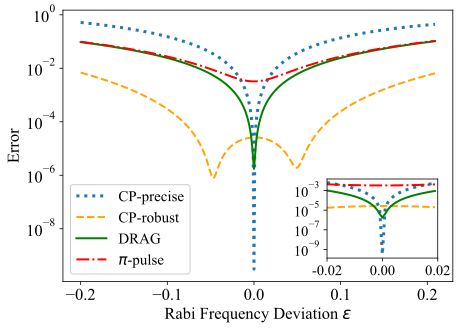

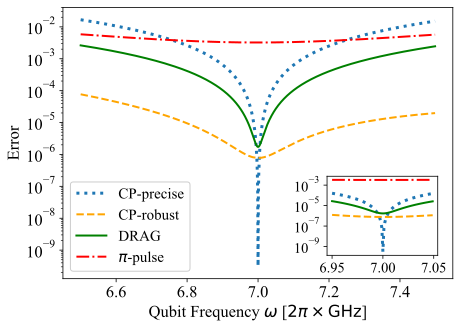

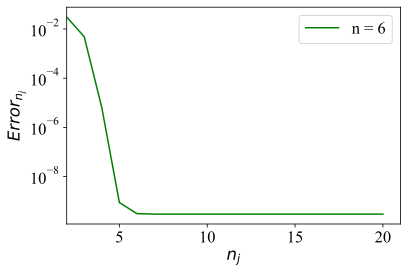

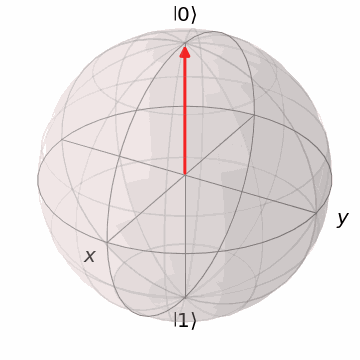

 c:\Users\hgton\anaconda3\lib\site-packages\qutip\solver\options.py: 16

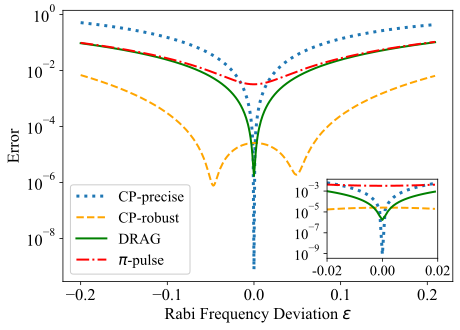

In [13]:
a1 = plot_results(res_pop,N = int(len(res_pop)/2),T = T,Prob = [0.,1.],operar = False, ops = 'X',name = f'pop_trans',dims = 6, x2 = res_pop_robust,anharm= False,show = False,time_Dep= False)
anharm1 = plot_results(res_pop,N = int(len(res_pop)/2),T = T,Prob = [0.,1.],operar = False, ops = 'X',name = f'pop_trans',dims = 6, x2 = res_pop_robust,anharm= True,show = True,time_Dep= False)
# We now plot the error with no assumed deviations in Rabbi frequency and anharmonicity
#  for a system with varying size and a pulse otimized for a 6 level system.
# This shows that the solution indeed converges to an optimal one for any system size larger than 6.
infidelity_operator(res_pop,initial_sizes = [dims],operatora = 'X',name = "Complete_pop_transfer",N = 7,T = T,prob = [0.,1.],vernoliop = False)

# Bloch sphere path. The function returns a time ordered animation of the Bloch sphere path, the initial and final states are red.
vecs, U_fx = get_vectors(res_pop_robust,T = T,dims = 6,init_state = [1.,0.])
plot_bloch_arrows(vecs,name = 'pop_transfer')

# Plot the results if we assume a fully time dependent H(t) as oposed to a sequence of N time independent Hamiltonians
a1_time = plot_results(res_pop,N = int(len(res_pop)/2),T = T,Prob = [0.,1.],operar = False, ops = 'X',name = f'pop_trans',dims = 6, x2 = res_pop_robust,anharm= False,show = False,time_Dep= True)


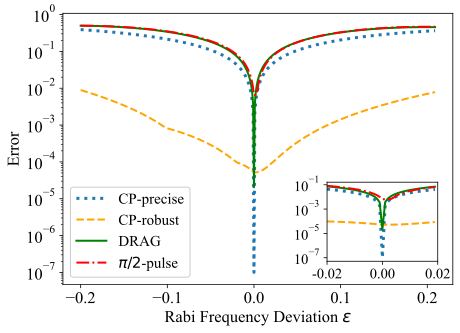

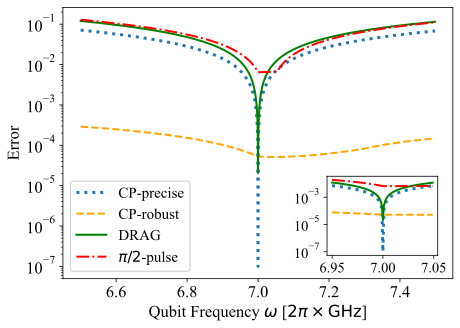

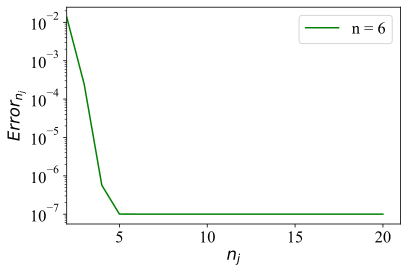

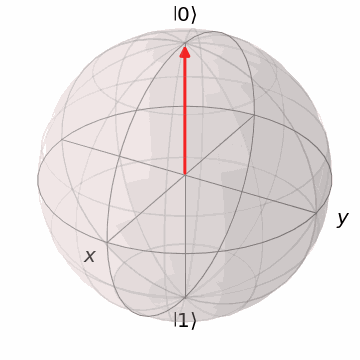

In [14]:
a1 = plot_results(res_sqrtX_opit,N = int(len(res_sqrtX_opit)/2),T = T,Prob = [0.5,0.5],operar = False, ops = 'sqrtX',name = f'half_pop_trans',dims = 6, x2 = res_pop_half_robust,anharm= False,show = True,time_Dep= False)
a1_frequency = plot_results(res_sqrtX_opit,N = int(len(res_sqrtX_opit)/2),T = T,Prob = [0.5,0.5],operar = False, ops = 'sqrtX',name = f'half_pop_trans',dims = 6, x2 = res_pop_half_robust,anharm= True,show = False)

infidelity_operator(res_sqrtX_opit,initial_sizes = [dims],operatora = 'sqrtX',name = "Half_pop_transfer",N = N,T = T,prob = [0.5,0.5],vernoliop = False)

vecs, U_fx = get_vectors(res_sqrtX_opit,T = T,dims = 6,init_state = [1.,0.])
plot_bloch_arrows(vecs,name = 'half_pop_transfer')

#Time dependent CP
#a1_time = plot_results(res_sqrtX_opit,N = int(len(res_sqrtX_opit)/2),T = T,Prob = [0.,1.],operar = False, ops = 'X',name = f'pop_trans',dims = 6, x2 = res_pop_half_robust,anharm= False,show = False,time_Dep= True)


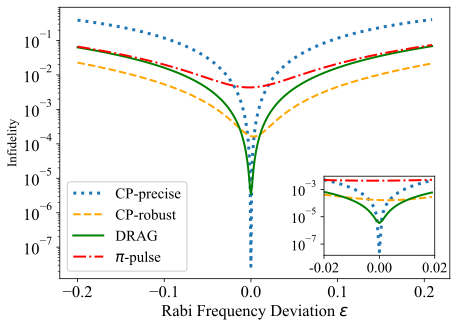

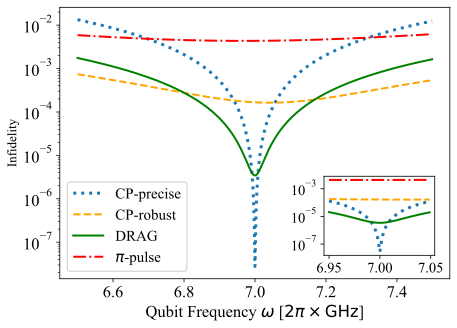

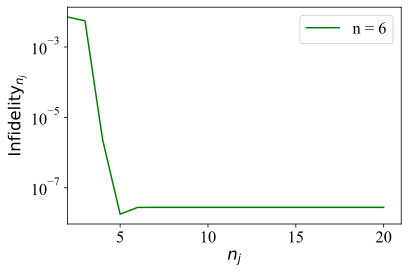

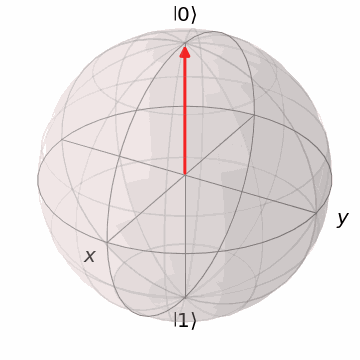

Leakeage: 2.7527909396418693e-08
Leakeage computed through "optimal_trace": 2.7527909507440995e-08
Infidelity: 2.7765728716211413e-08
Rotational error: 1.3942319299076189e-08
|c_z|^2: 2.042191128892954e-10


In [15]:
a1 = plot_results(res_X_opit,N = int(len(res_X_opit)/2),T = T,Prob = [0.,1.],operar = True, ops = 'X',name = f'X_gate',dims = 6, x2 = res_X_opit_robust,anharm= False,show = True,time_Dep= False)
a1_frequency = plot_results(res_X_opit,N = int(len(res_X_opit)/2),T = T,Prob = [0.,1.],operar = True, ops = 'X',name = f'X_gate',dims = 6, x2 = res_X_opit_robust,anharm= True,show = False)

infidelity_operator(res_X_opit,initial_sizes = [dims],operatora = 'X',name = "X_gate",N = N,T = T,prob = [0.,1.],vernoliop = True)

vecs, U_fx = get_vectors(res_X_opit,T = T,dims = 6,init_state = [1.,0.])
plot_bloch_arrows(vecs,name = 'X_gate')

coeffs = decompose_to_pauli(U_fx, delta=0.)
delta = sum(np.array(coeffs)*np.conj(coeffs)).real
fidelity, leakeage, rotational_error = optimal_trace(U_fx,create_gate('X',6),n = 2,seperate = True)

print('Leakeage:', 1-delta)
print('Leakeage computed through "optimal_trace":', leakeage)
print('Infidelity:', fidelity)
print('Rotational error:', rotational_error)
print('|c_z|^2:', (coeffs[3]*np.conj(coeffs[3])).real)

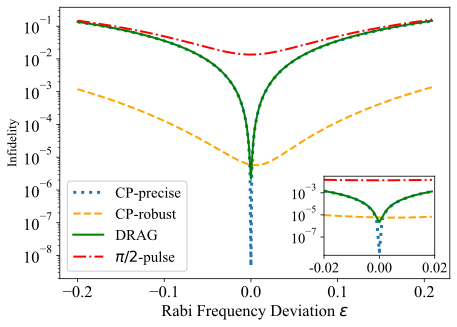

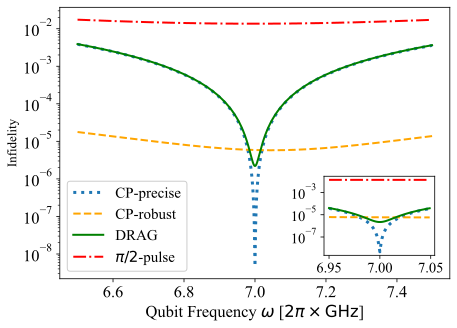

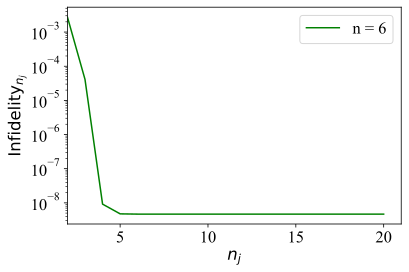

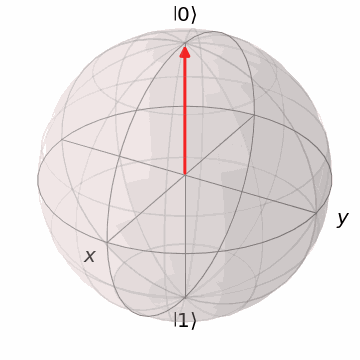

Leakeage: 4.237692086128675e-09
Leakeage computed through "optimal_trace": 4.237692086128675e-09
Infidelity: 4.673526676768347e-09
Rotational error: 2.445721958288516e-09
|c_z|^2: 1.549934325920449e-10


In [16]:
a1 = plot_results(res_sqrtX_opit,N = int(len(res_sqrtX_opit)/2),T = T,Prob = [0.5,0.5],operar = True, ops = 'sqrtX',name = f'sqrtX_gate',dims = 6, x2 = res_sqrtX_opit_robust,anharm = False,show = True,time_Dep = False)
a1_frequency = plot_results(res_sqrtX_opit,N = int(len(res_sqrtX_opit)/2),T = T,Prob = [0.5,0.5],operar = True, ops = 'sqrtX',name = f'sqrtX_gate',dims = 6, x2 = res_sqrtX_opit_robust,anharm = True,show = False)

infidelity_operator(res_sqrtX_opit,initial_sizes = [dims],operatora = 'sqrtX',name = "sqrtX_gate",N = N,T = T,prob = [0.5,0.5],vernoliop = True)


vecs, U_fx = get_vectors(res_sqrtX_opit,T = T,dims = 6,init_state = [1.,0.])
plot_bloch_arrows(vecs,name = 'sqrtX_gate')

coeffs = decompose_to_pauli(U_fx, delta=0.)
delta = sum(np.array(coeffs)*np.conj(coeffs)).real
fidelity, leakeage, rotational_error = optimal_trace(U_fx,create_gate('sqrtX',6),n = 2,seperate = True)

print('Leakeage:', 1-delta)
print('Leakeage computed through "optimal_trace":', leakeage)
print('Infidelity:', fidelity)
print('Rotational error:', rotational_error)
print('|c_z|^2:', (coeffs[3]*np.conj(coeffs[3])).real)

In [17]:
# Create the 2d anharmonicty and qubit frequency error plots for the CP solutions
# This code takes a while to run, so it is commented out.

#d_pop = plot_2d_qubit_anharmonicity(res_pop,N = int(len(res_pop)/2),T = T, operar = False,Prob = [0.,1.], ops = 'X',esuls = answer,pi_pulse = False,name = 'pop_trans',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = res_pop_robust,pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,pi_x_coef = res_y_X.x[0],drag_anharm_half = answer2_sqrt )
#d_pop = plot_2d_qubit_anharmonicity(res_sqrtX_opit,N = int(len(res_sqrtX_opit)/2), operar = False,Prob = [0.5,0.5], ops = 'sqrtX',esuls = answer,pi_pulse = False,name = 'half_pop_trans',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = res_pop_half_robust,pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,pi_x_coef = res_y_X.x[0],drag_anharm_half = answer2_sqrt )
#d_pop = plot_2d_qubit_anharmonicity(res_X_opit,N = int(len(res_X_opit)/2),T = T, operar = True,Prob = [0.,1.], ops = 'X',esuls = answer,pi_pulse = False,name = 'X_gate',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = res_X_opit_robust,pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,pi_x_coef = res_y_X.x[0],drag_anharm_half = answer2_sqrt )
#d_pop = plot_2d_qubit_anharmonicity(res_sqrtX_opit,N = int(len(res_sqrtX_opit)/2), operar = True,Prob = [0.5,0.5], ops = 'sqrtX',esuls = answer,pi_pulse = False,name = 'sqrtX_gate',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = res_sqrtX_opit_robust,pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,pi_x_coef = res_y_X.x[0],drag_anharm_half = answer2_sqrt )

# Create the 2d anharmonicity and qubit frequency error plots for the four pi-pulses
#d_pop = plot_2d_qubit_anharmonicity(res_pop,N = int(len(res_X_opit)/2),T = T, operar = False,Prob = [0.,1.], ops = 'X',esuls = answer,pi_pulse = True,name = 'pop_trans',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = [],pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,pi_x_coef = res_y_X.x[0],drag_anharm_half = answer2_sqrt )
#d_pop = plot_2d_qubit_anharmonicity(res_X_opit_robust,N = int(len(res_X_opit_robust)/2), operar = True,Prob = [0.,1.], ops = 'X',esuls = answer,pi_pulse = True,name = 'X_gate',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = [],pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,pi_x_coef = res_y_X.x[0],drag_anharm_half = answer2_sqrt )
#d_pop = plot_2d_qubit_anharmonicity(res_sqrtX_opit,N = int(len(res_sqrtX_opit)/2), operar = False,Prob = [0.5,0.5], ops = 'sqrtX',esuls = answer,pi_pulse = True,name = 'half_pop_trans',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = [],pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,pi_x_coef = res_y_X.x[0],drag_anharm_half = answer2_sqrt )
#d_pop = plot_2d_qubit_anharmonicity(res_sqrtX_opit_robust,N = int(len(res_sqrtX_opit_robust)/2), operar = True,Prob = [0.5,0.5], ops = 'sqrtX',esuls = answer,pi_pulse = True,name = 'sqrtX_gate',dims = 6,anharm = False,dragni_op = answer1,drag_harm = answer2,pulse_sqrt=res_y_half_sqrt.x[0],drag_X_harm = answer3,x2 = [],pi_coef = res_y.x[0],pi_coef_2 = res_y_half.x[0],show = False,drag_sqrtX_anharm = answer3_sqrtX,drag_sqrt_eps =  answer1_2,drag_half_eps = answer_2,pi_x_coef = res_y_X.x[0],drag_anharm_half = answer2_sqrt )
